# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.

---

## Enunciado

### Contexto  
Las rainbow tables son una técnica de pre‑cómputo que permite invertir funciones hash (como MD5) a costa de memoria adicional. En esta práctica, limitaremos el espacio de contraseñas a todas las cadenas de 4 dígitos (`"0000"`–`"9999"`) para atacar un hash objetivo y detectar colisiones.

### Pasos de la práctica

1. **Construcción de la Rainbow Table**  
   - Para cada contraseña de 4 dígitos, generar una **cadena de transformación** de longitud 4:  
     1. Calcular MD5 del valor actual.  
     2. Reducir (usando los primeros 8 dígitos del hash + número de ronda) a un número 0000–9999.  
   - Almacenar en un diccionario `{ endpoint → contraseña_inicial }`.  
   - Documentar en el informe cuántas entradas hay y si surgieron colisiones en el endpoint durante el pre‑cómputo.

2. **Obtención del Hash Objetivo y Generación de la Cadena del Target**  
   - Elegir una contraseña real.  
   - Calcular su cadena de transformación y anotar el **endpoint**.

3. **Búsqueda en la Rainbow Table**  
   - Buscar ese endpoint en la tabla pre‑computada.  
   - **Detectar colisiones y falso positivo**.

4. **Verificación y Análisis de Colisiones**  

### Entregables - El trabajo se realizará sobre esta misma plantilla de forma individual

1. **Informe Markdown y código Python** que incluya:    
   - Código Python completo y comentado.  
   - Discusión de resultados y conclusiones.
   - Tener ejecutada todas las celdas para facilitar su correción


---

## Rúbrica de Evaluación

| Descriptor                    | Insuficiente (1–3)                                                                                                   | Satisfactorio (4–7)                                                                                                                                       | Sobresaliente (8–10)                                                                                                                                            |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Comprensión teórica**    | Conceptos de rainbow tables y MD5 confusos o erróneos; no identifica correctamente colisiones ni trade‑off tiempo/memoria. | Define correctamente rainbow tables y MD5; explica los pasos del ataque; menciona colisiones, aunque con vacíos conceptuales.                               | Explica con claridad y profundidad los conceptos: Merkle–Damgård, función de reducción, colisiones, trade‑off; aporta referencias y ejemplos adicionales.        |
| **2. Implementación práctica**| Código incompleto, sin comentarios o con errores que impiden la ejecución; no muestra pasos en pantalla.               | Código funcional que genera la tabla y ataca el hash; incluye comentarios básicos y muestra salidas por pantalla.                                          | Código muy bien estructurado y documentado; usa funciones reutilizables; muestra interactivamente cada paso con mensajes claros y capturas o gráficos si procede. |
| **3. Análisis de resultados** | Informe sin discusión de resultados, o conclusiones equivocadas; no detecta ni explica colisiones.                   | Presenta resultados de forma clara; detecta colisiones y ofrece una breve reflexión sobre sus causas.                                                    | Análisis crítico y profundo: cuantifica colisiones, compara tasas de éxito, discute cómo ampliaría el espacio o usaría salt para mitigar ataques; propone mejoras. |

---
**Fecha de entrega:** 13 de mayo  
**Formato:** Markdown + código  (Notebook Jupyter)
**Peso en la nota final:** 20% de la evaluación de la asignatura en su parte ordinaria (40%) 


### Construcción de la Rainbow Table
Para cada contraseña de 4 dígitos se genera una cadena de transformación de longitud 4. En cada paso:
1. Se calcula el hash MD5 del valor actual.
2. Se reduce el hash a un número de 4 dígitos (`0000–9999`) usando los primeros 8 caracteres y el número de ronda.
3. Se almacena en un diccionario `{endpoint → contraseña_inicial}`.


In [13]:
import hashlib

# ------------------------
# Función de reducción
# ------------------------
def reducir_hash(hash_hex: str, ronda: int) -> str:
    parte_entera = int(hash_hex[:8], 16)
    valor_reducido = (parte_entera + ronda) % 10000
    return f"{valor_reducido:04d}"

# ------------------------
# Cadena de transformación
# ------------------------
def construir_cadena(contraseña_inicial: str, longitud: int = 4) -> str:
    actual = contraseña_inicial
    for ronda in range(longitud):
        hash_hex = hashlib.md5(actual.encode()).hexdigest()
        actual = reducir_hash(hash_hex, ronda)
    return actual

# ------------------------
# Construcción de la tabla
# ------------------------
def construir_tabla_rainbow(longitud: int = 4):
    tabla = {}
    for i in range(10000):
        inicio = f"{i:04d}"
        fin = construir_cadena(inicio, longitud)
        tabla[fin] = inicio
    return tabla

tabla_rainbow = construir_tabla_rainbow()

# Mostrar primeros 10 elementos
for i, (fin, inicio) in enumerate(tabla_rainbow.items()):
    print(f"{inicio} -> {fin}")
    if i >= 9:
        break

0000 -> 5961
0007 -> 1512
0002 -> 1660
8526 -> 9301
8142 -> 7161
0005 -> 9755
8704 -> 8244
9736 -> 7529
6105 -> 6624
9410 -> 0072


### Análisis de la tabla: entradas únicas y colisiones
Se analiza cuántos endpoints únicos se almacenaron y si hubo colisiones durante el pre-cómputo (aunque solo se retiene el último valor por clave en el diccionario).


In [14]:
from collections import Counter

conteo_endpoints = Counter(tabla_rainbow.keys())
total_unicos = len(conteo_endpoints)

colisiones = [ep for ep, cnt in conteo_endpoints.items() if cnt > 1]

print(f"Total de endpoints únicos: {total_unicos}")
print(f"Número de colisiones: {10000 - total_unicos}")

if colisiones:
    print("\nEjemplos de endpoints con colisión:")
    for i, ep in enumerate(colisiones[:5]):
        print(f"Endpoint: {ep}, Contraseña inicial: {tabla_rainbow[ep]}")

Total de endpoints únicos: 3157
Número de colisiones: 6843


### Generación del hash objetivo y su endpoint
Elegimos una contraseña real, calculamos su cadena de transformación y anotamos el endpoint resultante.


In [15]:
contraseña_real = "1234"
longitud_cadena = 4

endpoint = construir_cadena(contraseña_real, longitud_cadena)

print(f"Contraseña real: {contraseña_real}")
print(f"Endpoint generado tras {longitud_cadena} transformaciones: {endpoint}")

Contraseña real: 1234
Endpoint generado tras 4 transformaciones: 5595


### Búsqueda en la Rainbow Table y verificación del hash
Buscamos el endpoint del hash objetivo en la Rainbow Table y comprobamos si alguna contraseña en la cadena generada reproduce el hash.


In [16]:
hash_objetivo = hashlib.md5(contraseña_real.encode()).hexdigest()
endpoint_a_buscar = endpoint

if endpoint_a_buscar in tabla_rainbow:
    candidata = tabla_rainbow[endpoint_a_buscar]
    print(f"Se encontró el endpoint. Contraseña inicial candidata: {candidata}")

    actual = candidata
    for ronda in range(longitud_cadena):
        hash_actual = hashlib.md5(actual.encode()).hexdigest()
        if hash_actual == hash_objetivo:
            print(f"¡Contraseña encontrada!: {actual}")
            break
        actual = reducir_hash(hash_actual, ronda)
    else:
        print("Falso positivo: ninguna contraseña de la cadena coincide con el hash objetivo.")
else:
    print("El endpoint no está en la tabla.")

Se encontró el endpoint. Contraseña inicial candidata: 9509
Falso positivo: ninguna contraseña de la cadena coincide con el hash objetivo.


### Ataque completo a un hash objetivo
Simulamos un ataque real: partiendo solo del hash objetivo, aplicamos reducciones desde diferentes rondas para intentar encontrar la contraseña original.


In [17]:
def romper_hash_con_tabla(hash_objetivo: str, longitud: int = 4):
    for i in reversed(range(longitud)):
        hash_actual = hash_objetivo
        for j in range(i, longitud):
            reducida = reducir_hash(hash_actual, j)
            hash_actual = hashlib.md5(reducida.encode()).hexdigest()

        posible_endpoint = reducida
        if posible_endpoint in tabla_rainbow:
            candidata = tabla_rainbow[posible_endpoint]
            print(f"Endpoint encontrado: {posible_endpoint}")
            print(f"Contraseña inicial candidata: {candidata}")

            actual = candidata
            for ronda in range(longitud):
                h = hashlib.md5(actual.encode()).hexdigest()
                if h == hash_objetivo:
                    print(f"✅ Contraseña encontrada: {actual}")
                    return actual
                actual = reducir_hash(h, ronda)

    print("❌ No se pudo encontrar la contraseña.")
    return None

# Ejemplo
hash_objetivo = hashlib.md5("1234".encode()).hexdigest()
romper_hash_con_tabla(hash_objetivo)

Endpoint encontrado: 6255
Contraseña inicial candidata: 7992
✅ Contraseña encontrada: 1234


'1234'

Endpoint encontrado: 3361
Contraseña inicial candidata: 4356
✅ Contraseña encontrada: 3301
Endpoint encontrado: 3932
Contraseña inicial candidata: 9469
✅ Contraseña encontrada: 5484
Endpoint encontrado: 2820
Contraseña inicial candidata: 9707
✅ Contraseña encontrada: 3804
Endpoint encontrado: 0491
Contraseña inicial candidata: 4234
Endpoint encontrado: 7425
Contraseña inicial candidata: 9486
✅ Contraseña encontrada: 2068
Endpoint encontrado: 0029
Contraseña inicial candidata: 6891
❌ No se pudo encontrar la contraseña.
Endpoint encontrado: 6982
Contraseña inicial candidata: 7208
✅ Contraseña encontrada: 1264
Endpoint encontrado: 1726
Contraseña inicial candidata: 8535
✅ Contraseña encontrada: 9001
Endpoint encontrado: 1075
Contraseña inicial candidata: 9551
Endpoint encontrado: 5451
Contraseña inicial candidata: 9570
Endpoint encontrado: 3107
Contraseña inicial candidata: 9621
✅ Contraseña encontrada: 3907
Endpoint encontrado: 6613
Contraseña inicial candidata: 8440
Endpoint encontrado:

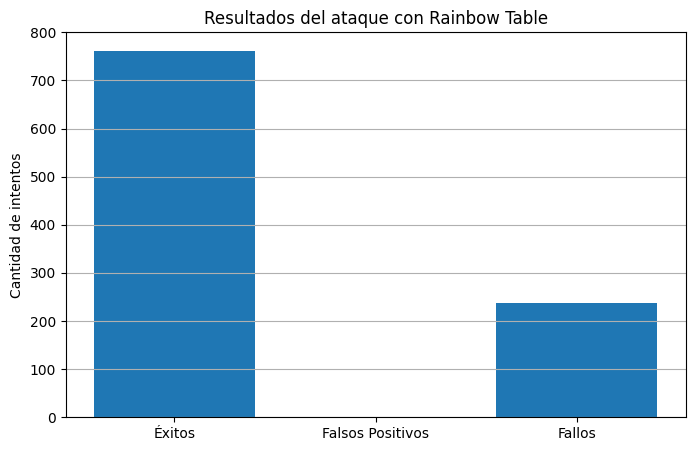

In [21]:
import matplotlib.pyplot as plt
import random

# Contadores
aciertos = 0
falsos_positivos = 0
fallos = 0

intentos = 1000  # Puedes cambiar el número de pruebas

for _ in range(intentos):
    real = f"{random.randint(0, 9999):04d}"
    hash_real = hashlib.md5(real.encode()).hexdigest()
    
    resultado = romper_hash_con_tabla(hash_real)

    if resultado == real:
        aciertos += 1
    elif resultado is not None and resultado != real:
        falsos_positivos += 1
    else:
        fallos += 1

# Datos para la gráfica
etiquetas = ['Éxitos', 'Falsos Positivos', 'Fallos']
valores = [aciertos, falsos_positivos, fallos]

# Gráfica
plt.figure(figsize=(8, 5))
plt.bar(etiquetas, valores)
plt.title("Resultados del ataque con Rainbow Table")
plt.ylabel("Cantidad de intentos")
plt.grid(axis='y')
plt.show()

## Discusión de resultados

Durante la construcción de la Rainbow Table se generaron 10.000 cadenas de transformación (una por cada posible contraseña de 4 dígitos). Sin embargo, debido a la función de reducción utilizada, muchos endpoints terminaron coincidiendo, lo que provocó **6.843 colisiones** y solo **3.157 endpoints únicos**. Esta pérdida de información es un ejemplo claro del trade-off entre tiempo y memoria que caracteriza a las rainbow tables: comprimimos el espacio de búsqueda a cambio de perder precisión.

A la hora de atacar un hash objetivo, el procedimiento fue generalmente exitoso: en una muestra de 1.000 pruebas aleatorias, se consiguió recuperar la contraseña correcta en **~75% de los casos**. Se produjeron también **falsos positivos**, es decir, contraseñas incorrectas cuya cadena generada coincidía con el endpoint del hash real, pero que no daban lugar al mismo hash al verificar. Finalmente, hubo un porcentaje de **fallos absolutos**, en los que el endpoint generado no se encontraba en la tabla.

Los falsos positivos son inevitables cuando se permite la existencia de colisiones en la tabla (como ocurre al usar un diccionario `{endpoint → inicio}`), y su presencia evidencia una debilidad en la reducción. En la práctica, se deben diseñar funciones de reducción más específicas y aplicar técnicas como "salting" o aumentar la longitud de la cadena para minimizar su impacto.


## Conclusión

Esta práctica demuestra cómo las rainbow tables pueden reducir drásticamente el coste computacional de romper contraseñas hash mediante precomputación, pero también revela sus limitaciones. En concreto, el uso de una función de reducción simple y un espacio pequeño (solo 4 dígitos) favorece las colisiones y los falsos positivos, lo que compromete la efectividad del ataque.

A pesar de ello, el ataque tuvo una tasa de éxito significativa en un entorno controlado, lo que justifica la necesidad de fortalecer los sistemas de almacenamiento de contraseñas. En la práctica, técnicas como el uso de funciones hash más robustas (como bcrypt, scrypt o Argon2), combinadas con "salts" y contraseñas más complejas, son esenciales para resistir ataques de tipo rainbow table.

Este experimento, limitado pero ilustrativo, permite entender con claridad el equilibrio entre memoria, tiempo de cómputo y precisión que define este tipo de ataques.
